#### Imporing the required liberaries

In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as math
%matplotlib inline
sns.set(style="whitegrid")

# Feature Engineering
from sklearn.preprocessing import StandardScaler


## Imports for Model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Imports for Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import warnings 
warnings.filterwarnings('ignore')


#### read data and save as dataframe

In [5]:
bank_df = pd.read_csv("Bank_Personal_Loan_Modelling.csv")

### **Exploratory Data Analysis**

In [6]:
# Check the Shape of the Data
bank_df.shape

(5000, 14)

there are 5000 observation with 14 features

In [7]:
bank_df.tail()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.8,1,0,0,0,0,1,1


- ID - unique identifier for the observation ( not needed for the prediction )

Independent Variable 
- Age , Experience , Income, ZIP Code, CCAvg,Mortgage  - Continuous variable 
- Family, Education - Ordinal categorical value
- Securities Account,CD Account	,Online,CreditCard - Binary Categorical value

Target Variable 
- Personal Loan - Binary Categorical value 

#### Check for missing data 

##### Standard missing value - values defined as  NA or null

In [8]:
bank_df.isna().any().any()

False

There is no missing values defined as NA or null

##### Non-Standard missing value - values entered as ( ??, -- ,N/A, 999 ,-999)

In [9]:
# Step 1 - Check the datatype 
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


- Since all the data type are int and float - it's clear that there is no abnormal string values like ( ???, N/A) ,if there is any value then data type will be Object

In [10]:
# Step 2 - Check unique value for feature to detect the abnormal value ( done for categorial values)

def print_uniqueValue(df,column_list):
    for column_name in column_list:
        print(column_name, "-", df[column_name].unique())

In [11]:
column_list = ["Family","Online","Education","Personal Loan","Securities Account","CD Account","Online","CreditCard"]
print_uniqueValue(bank_df,column_list)

Family - [4 3 1 2]
Online - [0 1]
Education - [1 2 3]
Personal Loan - [0 1]
Securities Account - [1 0]
CD Account - [0 1]
Online - [0 1]
CreditCard - [0 1]


Feature values are aligned as per the given requirement and we do not see any Non-Standard missing values.

- Max Family size id 4 ( ordinal categorical variable )
- Education is ordinal categorical variable with cardinality of 3 and it's encoded through Label Encoding which is the right imputation technique for ordinal categorical variable 
- Mortgage , Securities Account ,CD Account ,Online,CreditCard , Personal Loan - has value 0 or 1 ( Binary categorical value ) 


##### 5 point summary

In [12]:
data_5Summary = bank_df.describe().T
data_5Summary["IQR"] = data_5Summary["75%"] - data_5Summary["25%"]
data_5Summary["LOWER_LIMIT"] = data_5Summary["25%"] - (data_5Summary["IQR"] * 1.5)
data_5Summary["UPPER_LIMIT"] = data_5Summary["75%"] + (data_5Summary["IQR"] * 1.5)


#print(bank_df["Age"].quantile(0.75) - bank_df["Age"].quantile(0.25))
data_5Summary

,count,mean,std,min,25%,50%,75%,max,IQR,LOWER_LIMIT,UPPER_LIMIT
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0,2499.5,-2498.5,7499.5
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0,20.0,5.0,85.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0,20.0,-20.0,60.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0,59.0,-49.5,186.5
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0,2697.0,87865.5,98653.5
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0,2.0,-2.0,6.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0,1.8,-2.0,5.2
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0,2.0,-2.0,6.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0,101.0,-151.5,252.5
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0,0.0,0.0,0.0


- Age => mean is almost equal to median => distribution of data is symmetric. Type of the distribution can be found using visualization

- Experience - .mean is almost equal to median => distribution of data is symmetric but has negative value which need to be treated. 

- Income, CCAvg  - mean is greater than median --> which is long right tail => right skewed or postive skewed. 
- 10% of customer has Security Account 
- 6% of customer has CD account 
- 60% of customer use internet banking 
- 30% of customer use Credit card


#### **Data distribution for each attributes**

##### Data distribution  - ID

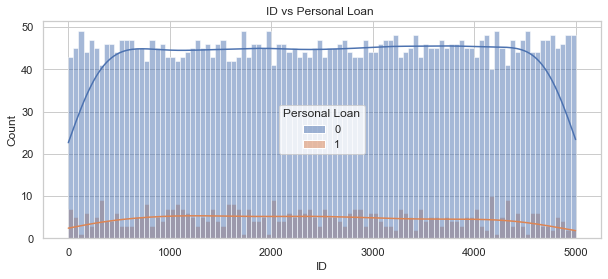

In [13]:
plt.figure(figsize=(10,4))
plt.title("ID vs Personal Loan ")
sns.histplot(data=bank_df,x="ID",hue="Personal Loan",bins=100,kde=True)
plt.show()    

- It's follows a uniform distribution and it has no correlation with the target variable ( Personal Loan ) 
- it's used only as Unique ID for the observation
- Conclusion - ID can be excluded for Target variable prediction.

##### Data distribution  - Age

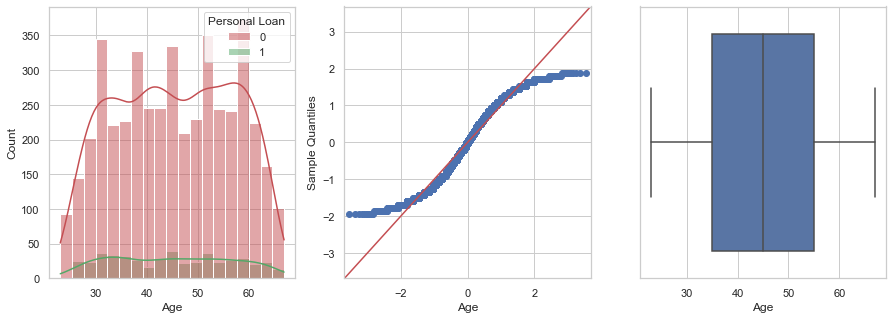

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))


sns.histplot(data = bank_df,x="Age",hue="Personal Loan",kde=True,ax=ax[0],palette=["r","g"])
sm.qqplot(bank_df["Age"],ax=ax[1],line='45',fit=True)
ax[1].set_xlabel("Age")
sns.boxplot(data=bank_df,x="Age",hue="Personal Loan",ax=ax[2])
plt.show()


- From Boxplot ==>  there is not Outliers
- From - Histplot & QQ plot ==> data follows the uniform distribution 
- From Histplot ==> people who got personal loan is distributed in all age.

##### Data distribution  - Experience

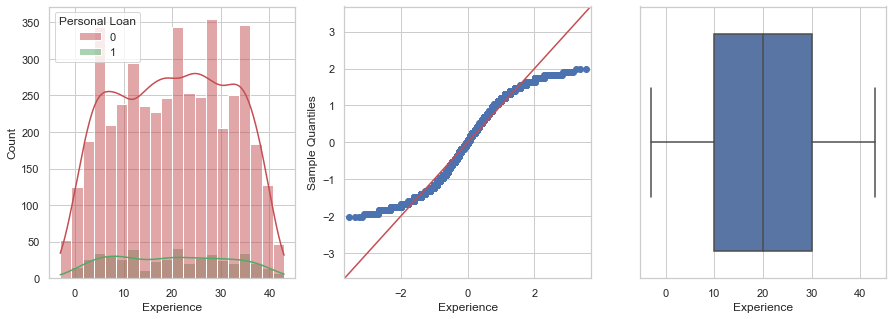

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))


sns.histplot(data = bank_df,x="Experience",hue="Personal Loan",kde=True,ax=ax[0],palette=["r","g"])
sm.qqplot(bank_df["Experience"],ax=ax[1],line='45',fit=True)
ax[1].set_xlabel("Experience")
sns.boxplot(data=bank_df,x="Experience",hue="Personal Loan",ax=ax[2])
plt.show()

- Experience has negative values which is not possible and need to be treated

###### Treat negative value in experience

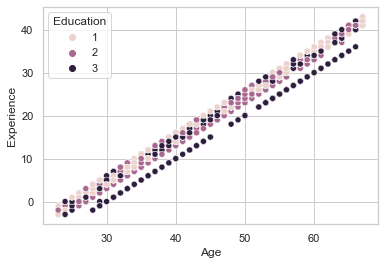

In [16]:
#Check how the Experience correlated with other value 
# Age & Education considered since in real word these 2 attribues influence the Experience

sns.scatterplot(data=bank_df,x="Age",y="Experience",hue="Education")

In [17]:
bank_df[["Age","Experience","Education"]].corr()

,Age,Experience,Education
Age,1.000000,0.994215,0.041334
Experience,0.994215,1.000000,0.013152
Education,0.041334,0.013152,1.000000


- From Scatterplot and Correlation Matrix ==> there is strong postive correlation bwt Age and Experience
- Conclusion ==> Mean value is calculated with in the "Age" to replace the missing value

In [18]:
# Compute Median value to replace the negative value
age_with_exp_negative = bank_df[bank_df["Experience"] <0]["Age"].unique()
age_experience_df = bank_df[(bank_df["Age"].isin(age_with_exp_negative) == True) &  (bank_df["Experience"] >= 0)][["Age","Experience"]]
def get_exp_summary_map():
    age_experience_map = {}
    for age in np.sort(age_with_exp_negative):
        experience_list = age_experience_df[age_experience_df["Age"] == age][["Experience"]]
        age_experience_map[age] = round(experience_list.mean().fillna(0)[0])
    return age_experience_map

In [19]:
# Create a new Imputed column for Expereince
age_experience_map = get_exp_summary_map()
def update_exp_value(row):
    if row["Experience"] < 0 :
        value = age_experience_map[row["Age"]]
    else:
        value = row["Experience"]
    return value

bank_df["Experience_imp"] = bank_df.apply(update_exp_value,axis=1)
bank_df[["Experience_imp","Experience"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Experience_imp,5000.0,20.1264,11.429180,0.0,10.0,20.0,30.0,43.0
Experience,5000.0,20.1046,11.467954,-3.0,10.0,20.0,30.0,43.0


##### Data distribution ( After Imputation ) - Experience

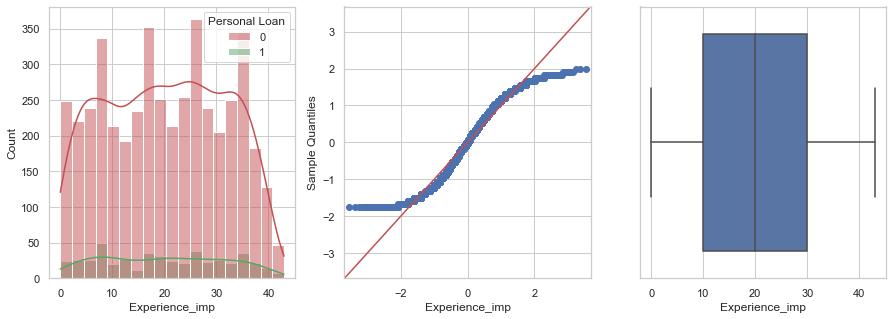

In [20]:
#  distribution after imputation ==> to Check is Imputation aftected the distribution

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

sns.histplot(data = bank_df,x="Experience_imp",hue="Personal Loan",kde=True,ax=ax[0],palette=["r","g"])
sm.qqplot(bank_df["Experience_imp"],ax=ax[1],line='45',fit=True)
ax[1].set_xlabel("Experience_imp")
sns.boxplot(data=bank_df,x="Experience_imp",hue="Personal Loan",ax=ax[2])
plt.show()


- No majar change in the distribution - negative values update with postive value

##### Data distribution - Income

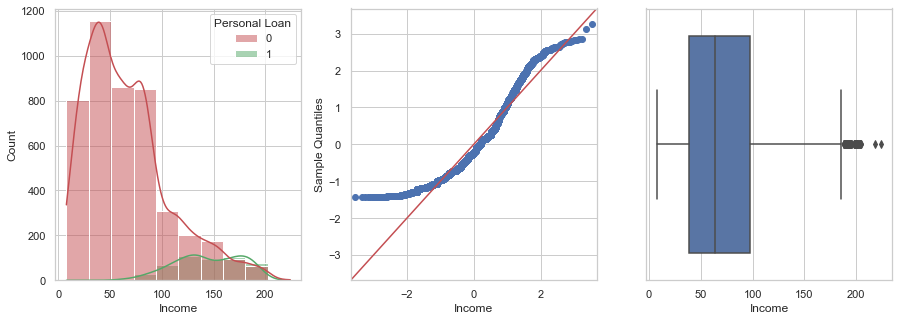

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

sns.histplot(data = bank_df,x="Income",hue="Personal Loan",kde=True,ax=ax[0],palette=["r","g"],bins=10)
sm.qqplot(bank_df["Income"],ax=ax[1],line='45',fit=True)
ax[1].set_xlabel("Income")
sns.boxplot(data=bank_df,x="Income",ax=ax[2])
plt.show()

- Right Skewed data, more outliers at the right side ==> Need to be treated using tranfromation technique
- Most of the customer with higher income has availed for personal loan which is comman behaviour in real world.

###### Oultier Engineering - Income

In [22]:
print("Original Skew Value ==> ", bank_df["Income"].skew())
print("Log Transformation Skew Value ==> ",np.log(bank_df["Income"]).skew())
print("Sqrt Transformation Skew Value ==> ",np.sqrt(bank_df["Income"]).skew())

Original Skew Value ==>  0.8413386072610816
Log Transformation Skew Value ==>  -0.46050403395988815
Sqrt Transformation Skew Value ==>  0.26043573246879353


- Sqrt Tranformation => reduce the skewness from 0.8 to 0.2

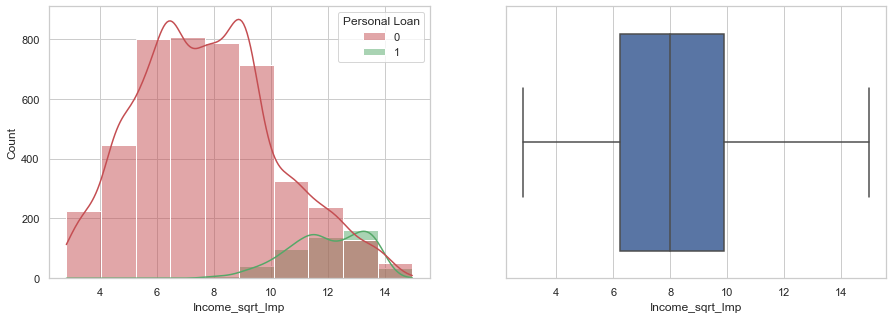

In [23]:
# Check the distribution after trasformation 
bank_df["Income_sqrt_Imp"] = np.sqrt(bank_df["Income"])

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.histplot(data = bank_df,x="Income_sqrt_Imp",hue="Personal Loan",kde=True,ax=ax[0],palette=["r","g"],bins=10)
sns.boxplot(data=bank_df,x="Income_sqrt_Imp",ax=ax[1])
plt.show()

- After the Sqrt transformation, outliers are handled and no major change is distribution.
- Model can be experimented with and without Imputed column for best performance

##### Data distribution - CCAvg

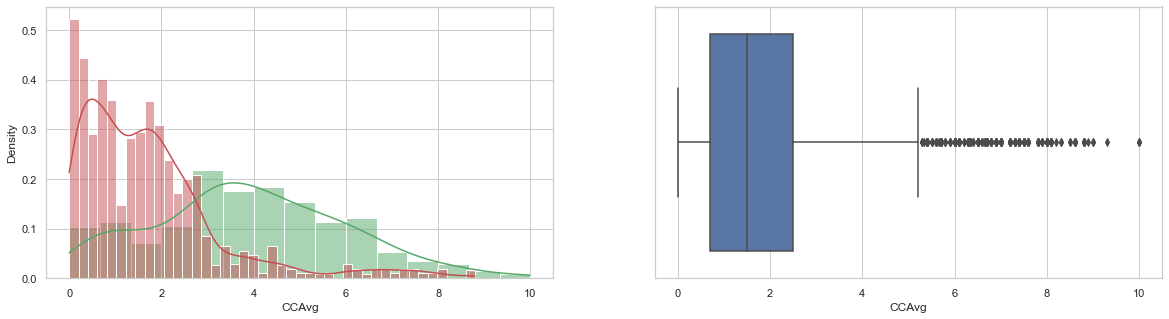

<Figure size 1440x360 with 0 Axes>

Average CCAvg with Personal loan 3.9053541666666662
Average CCAvg with out Personal loan 1.7290088495575293


In [24]:
##### Data distribution - CCAvg

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))

plt.figure(figsize=(20,5))
sns.histplot(data = bank_df[bank_df["Personal Loan"] == 1],color="g" ,x="CCAvg",kde=True,stat="density",ax=ax[0]) 
sns.histplot(data = bank_df[bank_df["Personal Loan"] == 0],color="r",x="CCAvg",kde=True,stat="density",ax=ax[0])
sns.boxplot(data=bank_df,x="CCAvg",ax=ax[1])
plt.show()

print("Average CCAvg with Personal loan", bank_df[bank_df["Personal Loan"] == 1]["CCAvg"].mean())
print("Average CCAvg with out Personal loan", bank_df[bank_df["Personal Loan"] == 0]["CCAvg"].mean())

- Observation ==> Right Skewed data, more outliers at the right side 
    - Conclusion ==> Need to be treated using transformation technique or scaling techniques 
- Observation ==> Average spending though credit card is higher for client who has availed for personal loan.
    - Conclusion ==> CCAvg has influence on Personal Loan 

###### Oultier Engineering - CCAvg

In [25]:
print("Original Skew Value ==> ", bank_df["CCAvg"].skew())
print("Sqrt Transformation Skew Value ==> ",np.sqrt(bank_df["CCAvg"]).skew())

Original Skew Value ==>  1.5984433366678663
Sqrt Transformation Skew Value ==>  0.424026404519258


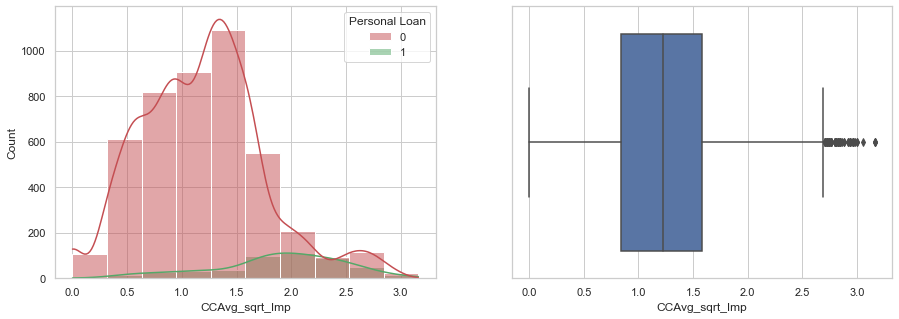

In [26]:
# Check the distribution after trasformation 
bank_df["CCAvg_sqrt_Imp"] = np.sqrt(bank_df["CCAvg"])

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.histplot(data = bank_df,x="CCAvg_sqrt_Imp",hue="Personal Loan",kde=True,ax=ax[0],palette=["r","g"],bins=10)
sns.boxplot(data=bank_df,x="CCAvg_sqrt_Imp",ax=ax[1])
plt.show()

- Sqrt Tranformation => reduce the skewness from 1.5 to 0.4

##### Data distribution - Mortgage

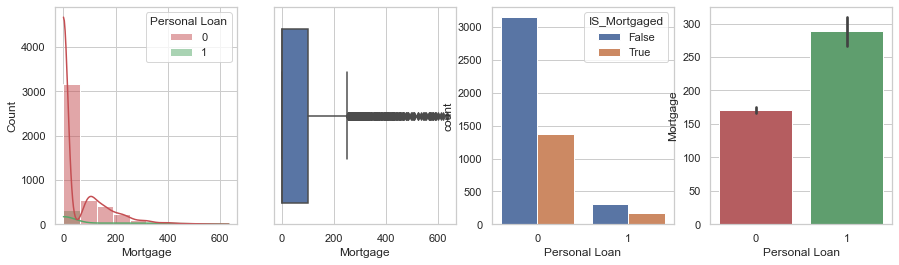

In [27]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(15,4))

sns.histplot(data = bank_df,x="Mortgage",hue="Personal Loan",kde=True,ax=ax[0],palette=["r","g"],bins=10)
sns.boxplot(data=bank_df,x="Mortgage",ax=ax[1])

bank_df["IS_Mortgaged"] = [True if value > 0 else False for value in bank_df["Mortgage"]]
sns.countplot(data=bank_df,x="Personal Loan",hue="IS_Mortgaged",ax=ax[2])

sns.barplot(data=bank_df[bank_df["IS_Mortgaged"] == True],x="Personal Loan",y="Mortgage",estimator=np.mean,palette=["r","g"])

plt.show()


- Observation 
   - Distribution is right skewed, Can be treated using transformation or scaling technique
   - No of clients who has no personal loan and with Mortgage is high when compare to the client with personal loan and with Mortgage.
   - Avg Mortgage amount for Clients who got the personal loan is greater than clients with out personal loan
 
- Conclusion 
    - When considering the Avg Mortgage amount it has influence on Personal loan, Model metric can be check based on including and excluding the feature   

##### Data distribution - ZIP Code

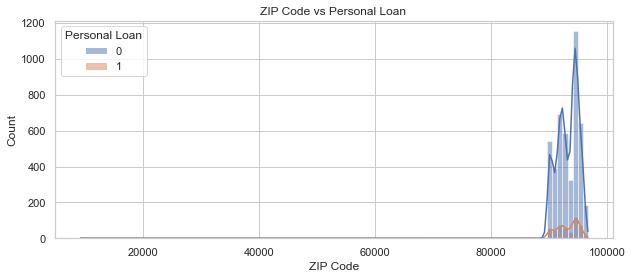

In [28]:
plt.figure(figsize=(10,4))
plt.title("ZIP Code vs Personal Loan ")
sns.histplot(data=bank_df,x="ZIP Code",hue="Personal Loan",bins=100,kde=True)
plt.show()   

- Similar to ID feature,  Zip code has not influence on Personal Loan which can be removed for prediction

##### Data distribution -  'Family','Education','Securities Account','CD Account', 'Online', 'CreditCard'

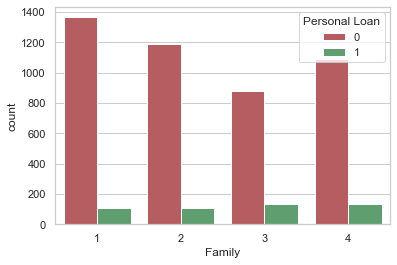

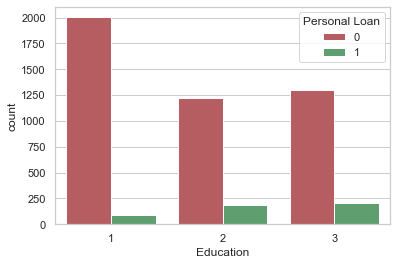

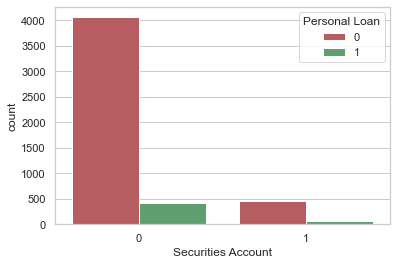

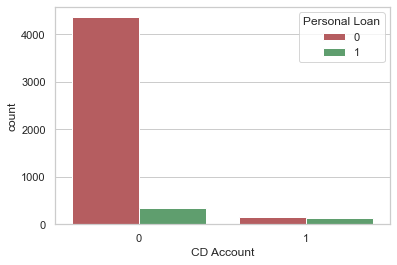

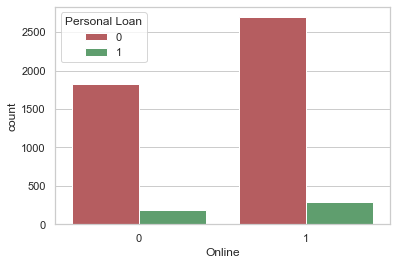

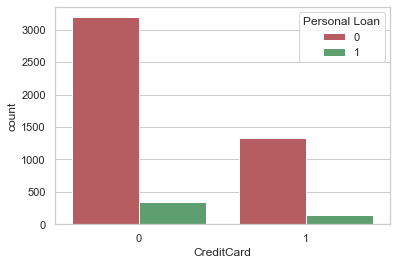

In [29]:
columns_list = ['Family','Education','Securities Account','CD Account', 'Online', 'CreditCard']
for column_name in columns_list:
    sns.countplot(data=bank_df,x=column_name,hue="Personal Loan",palette=["r","g"])
    plt.show()


- Observation
    - Family - there is no much impact on personal loan considering Family size.
    - Education - No of Customers with Higher education level ( 2 ,3 ) has takn more personal loan than with lower education level (1) ==>  Eduction has influence on the Personal Loan.
    - Customers who has no 'Securities Account','CD Account' has availed for personal loan more than Customer with  'Securities Account','CD Account'
    - Online tranaction - Customers who do online transaction has availed for personal loan little more than customer with out online transaction --> More advertisements through online and ability to request / approve personal loan through online portal can create this impact.
    - Credit Card --> Cutomer with out Credit card has availed for Personal Loan more that Customer with credit card. -> may be the customer can buy a credit card loan rather than personal loan 
       
    
    

#### **Data distribution for target variable ( " Personal Loan " )**

 % of Observation with PL = 1 0.096
 % of Observation with PL = 0  0.904


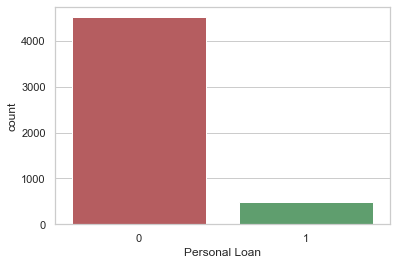

In [30]:
sns.countplot(data=bank_df,x="Personal Loan",palette=["r","g"])
print(" % of Observation with PL = 1" , bank_df[bank_df["Personal Loan"] == 1]["Personal Loan"].count() / 5000)
print(" % of Observation with PL = 0 " , bank_df[bank_df["Personal Loan"] == 0]["Personal Loan"].count() / 5000)

- 10% of Observation has personal loan 1 and 90% of observation has Personal loan 0 .
- Dataset is more skewed toward the personal loan  = 0 
- Advised to check the distribution of personal loan in  train and test data to avoid over/under fit 

#### Check for Multicolinearity or  Correlation

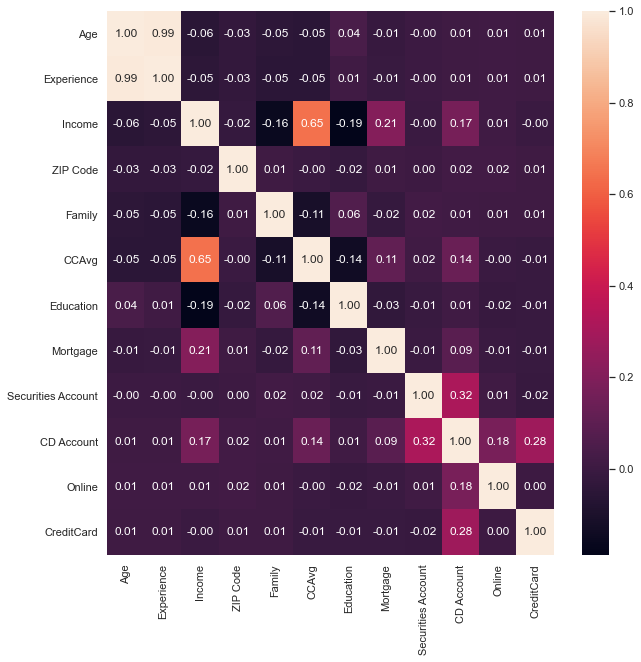

In [31]:
bank_df.columns

correlation_matrix= bank_df[['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg','Education', 'Mortgage', 'Securities Account',
       'CD Account', 'Online', 'CreditCard']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix,annot=True,fmt='.2f')
plt.show()

- Strong positive correlation is bwt Age and Experience ==> Experience can be removed along with "ID" and "ZIP Code"
- drop "ID","Experience","Zip Code" from model building
- Income and CCAvg has week postive correlation ==> Error and trail can be done by removing CCAvg value 

#### **Model building**

- ID and Zip Code is not relevant to the model building.
- Other features will be involved in a error and trail method.

In [32]:
def check_distribution(traindata,testdata,columns_list):
    for column_name in columns_list:
        print("---------------",column_name,"------------")
        print(round(traindata[column_name].value_counts() / traindata[column_name].count(),2)*100)
        print(round(testdata[column_name].value_counts() / testdata[column_name].count(),2)*100)
        
metrics_data_df = pd.DataFrame(columns=["type","iter_no","neighbors","test_score","train_score","TPR","PPR","f1_score","FPR","roc_auc","confusion_matrix_obj"])

dependent_variable = ["Personal Loan"]
        

##### Logistic Regression - Iteration 1
- Iteration - 1 :- 
    - Model build with variable with out transformation or scaling 
    - Experience is not included as it has negative value


In [33]:
iv_iteration1_lr = ['Age',  'Income','Family', 'CCAvg','Education', 'Mortgage',
                    'Securities Account','CD Account', 'Online', 'CreditCard']


# Train and test data split
X = bank_df[iv_iteration1_lr]
Y = bank_df[dependent_variable]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=101)


# Check the distribution in train and test for categorial value
print('x train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('x test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

# Check the distribution for Categorial value - Independent Variable
check_distribution(X_train,X_test, ['Family','Education', 'Securities Account','CD Account', 'Online', 'CreditCard'])

# Check the distribution for Categorial value - Dependent variable
check_distribution(y_train,y_test,["Personal Loan"])

# Train and test model

lg = LogisticRegression(solver="liblinear")
lg.fit(X_train,y_train)
y_predict = lg.predict(X_test)

#Metrics calculation
fpr,tpr,threshold = roc_curve(y_test,y_predict)
roc_auc  = auc(fpr, tpr)

lg_Iter1_metrics_disc = dict()
lg_Iter1_metrics_disc = {"type":"lr",
                         "iter_no":1,
                         "train_score":round(lg.score(X_train,y_train),2),
                         "test_score":round(lg.score(X_test,y_test),2),
                         "TPR":round(recall_score(y_test,y_predict),2),
                         "PPR":round(precision_score(y_test,y_predict),2),
                         "f1_score":round(f1_score(y_test,y_predict),2),
                         "FPR":round(fpr[1],2),
                         "roc_auc":round(roc_auc,2),
                         "confusion_matrix_obj":confusion_matrix(y_test,y_predict,[0,1])}

metrics_data_df = metrics_data_df.append(lg_Iter1_metrics_disc,ignore_index=True)

x train data (3500, 10)
y train data (3500, 1)
x test data  (1500, 10)
y test data  (1500, 1)
--------------- Family ------------
1    30.0
2    25.0
4    25.0
3    20.0
Name: Family, dtype: float64
1    29.0
2    27.0
4    23.0
3    21.0
Name: Family, dtype: float64
--------------- Education ------------
1    41.0
3    31.0
2    28.0
Name: Education, dtype: float64
1    43.0
3    29.0
2    28.0
Name: Education, dtype: float64
--------------- Securities Account ------------
0    90.0
1    10.0
Name: Securities Account, dtype: float64
0    89.0
1    11.0
Name: Securities Account, dtype: float64
--------------- CD Account ------------
0    94.0
1     6.0
Name: CD Account, dtype: float64
0    94.0
1     6.0
Name: CD Account, dtype: float64
--------------- Online ------------
1    59.0
0    41.0
Name: Online, dtype: float64
1    60.0
0    40.0
Name: Online, dtype: float64
--------------- CreditCard ------------
0    70.0
1    30.0
Name: CreditCard, dtype: float64
0    72.0
1    28.0
Name: 

##### Logistic Regression - Iteration 2
- Iteration - 2 :- 
    - Model build with variable with transformation 
    - Imputed Experience feature is included by removing the negative experience

In [34]:
iv_iteration2_lr = ['Age',  'Income_sqrt_Imp','Family', 'CCAvg_sqrt_Imp',
       'Education', 'Mortgage','Securities Account',
       'CD Account', 'Online', 'CreditCard', 'Experience_imp']

# Train and test data split
X = bank_df[iv_iteration2_lr]
Y = bank_df[dependent_variable]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=101)


# Check the distribution in train and test for categorial value
print('x train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('x test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

# Check the distribution for Categorial value - Independent Variable
check_distribution(X_train,X_test, ['Family','Education', 'Securities Account','CD Account', 'Online', 'CreditCard'])

# Check the distribution for Categorial value - Dependent variable
check_distribution(y_train,y_test,["Personal Loan"])

# Train and test model

lg = LogisticRegression(solver="liblinear")
lg.fit(X_train,y_train)
y_predict = lg.predict(X_test)

#Metrics calculation
fpr,tpr,threshold = roc_curve(y_test,y_predict)
roc_auc  = auc(fpr, tpr)

lg_Iter1_metrics_disc = dict()
lg_Iter1_metrics_disc = {"type":"lr",
                         "iter_no":2,
                         "train_score":round(lg.score(X_train,y_train),2),
                         "test_score":round(lg.score(X_test,y_test),2),
                         "TPR":round(recall_score(y_test,y_predict),2),
                         "PPR":round(precision_score(y_test,y_predict),2),
                         "f1_score":round(f1_score(y_test,y_predict),2),
                         "FPR":round(fpr[1],2),
                         "roc_auc":round(roc_auc,2),
                         "confusion_matrix_obj":confusion_matrix(y_test,y_predict,[0,1])}

metrics_data_df = metrics_data_df.append(lg_Iter1_metrics_disc,ignore_index=True)

x train data (3500, 11)
y train data (3500, 1)
x test data  (1500, 11)
y test data  (1500, 1)
--------------- Family ------------
1    30.0
2    25.0
4    25.0
3    20.0
Name: Family, dtype: float64
1    29.0
2    27.0
4    23.0
3    21.0
Name: Family, dtype: float64
--------------- Education ------------
1    41.0
3    31.0
2    28.0
Name: Education, dtype: float64
1    43.0
3    29.0
2    28.0
Name: Education, dtype: float64
--------------- Securities Account ------------
0    90.0
1    10.0
Name: Securities Account, dtype: float64
0    89.0
1    11.0
Name: Securities Account, dtype: float64
--------------- CD Account ------------
0    94.0
1     6.0
Name: CD Account, dtype: float64
0    94.0
1     6.0
Name: CD Account, dtype: float64
--------------- Online ------------
1    59.0
0    41.0
Name: Online, dtype: float64
1    60.0
0    40.0
Name: Online, dtype: float64
--------------- CreditCard ------------
0    70.0
1    30.0
Name: CreditCard, dtype: float64
0    72.0
1    28.0
Name: 

In [35]:
metrics_data_df

,type,iter_no,neighbors,test_score,train_score,TPR,PPR,f1_score,FPR,roc_auc,confusion_matrix_obj
0,lr,1,NaN,0.95,0.95,0.53,0.89,0.66,0.01,0.76,"[[1344, 10], [69, 77]]"
1,lr,2,NaN,0.95,0.95,0.55,0.89,0.68,0.01,0.77,"[[1344, 10], [66, 80]]"


##### Logistic Regression - Iteration 3
- Iteration - 3 :-  Removing the to dependent variable (CCAvg which has correlation with income) and adding the imputed experience feature

In [36]:
iv_iteration3_lr = ['Age',  'Income','Family',
       'Education', 'Mortgage','Securities Account',
       'CD Account', 'Online', 'CreditCard',"Experience_imp"]

# Train and test data split
X = bank_df[iv_iteration3_lr]
Y = bank_df[dependent_variable]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=101)


# Check the distribution in train and test for categorial value
print('x train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('x test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

# Check the distribution for Categorial value - Independent Variable
check_distribution(X_train,X_test, ['Family','Education', 'Securities Account','CD Account', 'Online', 'CreditCard'])

# Check the distribution for Categorial value - Dependent variable
check_distribution(y_train,y_test,["Personal Loan"])

# Train and test model

lg = LogisticRegression(solver="liblinear")
lg.fit(X_train,y_train)
y_predict = lg.predict(X_test)

#Metrics calculation
fpr,tpr,threshold = roc_curve(y_test,y_predict)
roc_auc  = auc(fpr, tpr)

lg_Iter1_metrics_disc = dict()
lg_Iter1_metrics_disc = {"type":"lr",
                         "iter_no":3,
                         "train_score":round(lg.score(X_train,y_train),2),
                         "test_score":round(lg.score(X_test,y_test),2),
                         "TPR":round(recall_score(y_test,y_predict),2),
                         "PPR":round(precision_score(y_test,y_predict),2),
                         "f1_score":round(f1_score(y_test,y_predict),2),
                         "FPR":round(fpr[1],2),
                         "roc_auc":round(roc_auc,2),
                         "confusion_matrix_obj":confusion_matrix(y_test,y_predict,[0,1])}

metrics_data_df = metrics_data_df.append(lg_Iter1_metrics_disc,ignore_index=True)

x train data (3500, 10)
y train data (3500, 1)
x test data  (1500, 10)
y test data  (1500, 1)
--------------- Family ------------
1    30.0
2    25.0
4    25.0
3    20.0
Name: Family, dtype: float64
1    29.0
2    27.0
4    23.0
3    21.0
Name: Family, dtype: float64
--------------- Education ------------
1    41.0
3    31.0
2    28.0
Name: Education, dtype: float64
1    43.0
3    29.0
2    28.0
Name: Education, dtype: float64
--------------- Securities Account ------------
0    90.0
1    10.0
Name: Securities Account, dtype: float64
0    89.0
1    11.0
Name: Securities Account, dtype: float64
--------------- CD Account ------------
0    94.0
1     6.0
Name: CD Account, dtype: float64
0    94.0
1     6.0
Name: CD Account, dtype: float64
--------------- Online ------------
1    59.0
0    41.0
Name: Online, dtype: float64
1    60.0
0    40.0
Name: Online, dtype: float64
--------------- CreditCard ------------
0    70.0
1    30.0
Name: CreditCard, dtype: float64
0    72.0
1    28.0
Name: 

In [37]:
metrics_data_df

,type,iter_no,neighbors,test_score,train_score,TPR,PPR,f1_score,FPR,roc_auc,confusion_matrix_obj
0,lr,1,NaN,0.95,0.95,0.53,0.89,0.66,0.01,0.76,"[[1344, 10], [69, 77]]"
1,lr,2,NaN,0.95,0.95,0.55,0.89,0.68,0.01,0.77,"[[1344, 10], [66, 80]]"
2,lr,3,NaN,0.95,0.95,0.54,0.90,0.68,0.01,0.77,"[[1345, 9], [67, 79]]"


##### Logistic Regression - Iteration 4
- Iteration - 4 :-  by scaling the features

In [38]:
iv_iteration4_lr = ['Age',  'Income','Family', 'CCAvg','Education', 'Mortgage','Securities Account',
                    'CD Account', 'Online', 'CreditCard']

# Train and test data split
X = bank_df[iv_iteration4_lr]
Y = bank_df[dependent_variable]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=101)


# Check the distribution in train and test for categorial value
print('x train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('x test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

# Check the distribution for Categorial value - Independent Variable
check_distribution(X_train,X_test, ['Family','Education', 'Securities Account','CD Account', 'Online', 'CreditCard'])

# Check the distribution for Categorial value - Dependent variable
check_distribution(y_train,y_test,["Personal Loan"])


# Scaling the attributes 
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


# Train and test model

lg = LogisticRegression(solver="liblinear")
lg.fit(X_train,y_train)
y_predict = lg.predict(X_test)

#Metrics calculation
fpr,tpr,threshold = roc_curve(y_test,y_predict)
roc_auc  = auc(fpr, tpr)

lg_Iter1_metrics_disc = dict()
lg_Iter1_metrics_disc = {"type":"lr",
                         "iter_no":4,
                         "train_score":round(lg.score(X_train,y_train),2),
                         "test_score":round(lg.score(X_test,y_test),2),
                         "TPR":round(recall_score(y_test,y_predict),2),
                         "PPR":round(precision_score(y_test,y_predict),2),
                         "f1_score":round(f1_score(y_test,y_predict),2),
                         "FPR":round(fpr[1],2),
                         "roc_auc":round(roc_auc,2),
                         "confusion_matrix_obj":confusion_matrix(y_test,y_predict,[0,1])}

metrics_data_df = metrics_data_df.append(lg_Iter1_metrics_disc,ignore_index=True)



x train data (3500, 10)
y train data (3500, 1)
x test data  (1500, 10)
y test data  (1500, 1)
--------------- Family ------------
1    30.0
2    25.0
4    25.0
3    20.0
Name: Family, dtype: float64
1    29.0
2    27.0
4    23.0
3    21.0
Name: Family, dtype: float64
--------------- Education ------------
1    41.0
3    31.0
2    28.0
Name: Education, dtype: float64
1    43.0
3    29.0
2    28.0
Name: Education, dtype: float64
--------------- Securities Account ------------
0    90.0
1    10.0
Name: Securities Account, dtype: float64
0    89.0
1    11.0
Name: Securities Account, dtype: float64
--------------- CD Account ------------
0    94.0
1     6.0
Name: CD Account, dtype: float64
0    94.0
1     6.0
Name: CD Account, dtype: float64
--------------- Online ------------
1    59.0
0    41.0
Name: Online, dtype: float64
1    60.0
0    40.0
Name: Online, dtype: float64
--------------- CreditCard ------------
0    70.0
1    30.0
Name: CreditCard, dtype: float64
0    72.0
1    28.0
Name: 

#####  Naïve Bayes - Iteration 1
- Iteration - 1 :- 
    - Model build with variable with out transformation or scaling 
    - Experience is not included as it has negative value

In [39]:
iv_iteration1_lr = ['Age',  'Income','Family', 'CCAvg','Education', 'Mortgage',
                    'Securities Account','CD Account', 'Online', 'CreditCard']


# Train and test data split
X = bank_df[iv_iteration1_lr]
Y = bank_df[dependent_variable]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=101)


# Check the distribution in train and test for categorial value
print('x train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('x test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

# Check the distribution for Categorial value - Independent Variable
check_distribution(X_train,X_test, ['Family','Education', 'Securities Account','CD Account', 'Online', 'CreditCard'])

# Check the distribution for Categorial value - Dependent variable
check_distribution(y_train,y_test,["Personal Loan"])

# Train and test model

model = GaussianNB()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

#Metrics calculation
fpr,tpr,threshold = roc_curve(y_test,y_predict)
roc_auc  = auc(fpr, tpr)

metrics_disc = dict()
metrics_disc = {"type":"nb",
                         "iter_no":1,
                         "train_score":round(model.score(X_train,y_train),2),
                         "test_score":round(model.score(X_test,y_test),2),
                         "TPR":round(recall_score(y_test,y_predict),2),
                         "PPR":round(precision_score(y_test,y_predict),2),
                         "f1_score":round(f1_score(y_test,y_predict),2),
                         "FPR":round(fpr[1],2),
                         "roc_auc":round(roc_auc,2),
                         "confusion_matrix_obj":confusion_matrix(y_test,y_predict,[0,1])}

metrics_data_df = metrics_data_df.append(metrics_disc,ignore_index=True)

x train data (3500, 10)
y train data (3500, 1)
x test data  (1500, 10)
y test data  (1500, 1)
--------------- Family ------------
1    30.0
2    25.0
4    25.0
3    20.0
Name: Family, dtype: float64
1    29.0
2    27.0
4    23.0
3    21.0
Name: Family, dtype: float64
--------------- Education ------------
1    41.0
3    31.0
2    28.0
Name: Education, dtype: float64
1    43.0
3    29.0
2    28.0
Name: Education, dtype: float64
--------------- Securities Account ------------
0    90.0
1    10.0
Name: Securities Account, dtype: float64
0    89.0
1    11.0
Name: Securities Account, dtype: float64
--------------- CD Account ------------
0    94.0
1     6.0
Name: CD Account, dtype: float64
0    94.0
1     6.0
Name: CD Account, dtype: float64
--------------- Online ------------
1    59.0
0    41.0
Name: Online, dtype: float64
1    60.0
0    40.0
Name: Online, dtype: float64
--------------- CreditCard ------------
0    70.0
1    30.0
Name: CreditCard, dtype: float64
0    72.0
1    28.0
Name: 

#####  Naïve Bayes - Iteration 2
- Iteration - 2 :- 
    - Model build with variable with scaling 
    - Experience is not included as it has negative value

In [40]:
iv_iteration1_lr = ['Age',  'Income','Family', 'CCAvg','Education', 'Mortgage',
                    'Securities Account','CD Account', 'Online', 'CreditCard']


# Train and test data split
X = bank_df[iv_iteration1_lr]
Y = bank_df[dependent_variable]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=101)


# Check the distribution in train and test for categorial value
print('x train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('x test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

# Check the distribution for Categorial value - Independent Variable
check_distribution(X_train,X_test, ['Family','Education', 'Securities Account','CD Account', 'Online', 'CreditCard'])

# Check the distribution for Categorial value - Dependent variable
check_distribution(y_train,y_test,["Personal Loan"])

# Scaling the attributes 
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Train and test model

model = GaussianNB()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

#Metrics calculation
fpr,tpr,threshold = roc_curve(y_test,y_predict)
roc_auc  = auc(fpr, tpr)

metrics_disc = dict()
metrics_disc = {"type":"nb",
                         "iter_no":2,
                         "train_score":round(model.score(X_train,y_train),2),
                         "test_score":round(model.score(X_test,y_test),2),
                         "TPR":round(recall_score(y_test,y_predict),2),
                         "PPR":round(precision_score(y_test,y_predict),2),
                         "f1_score":round(f1_score(y_test,y_predict),2),
                         "FPR":round(fpr[1],2),
                         "roc_auc":round(roc_auc,2),
                         "confusion_matrix_obj":confusion_matrix(y_test,y_predict,[0,1])}

metrics_data_df = metrics_data_df.append(metrics_disc,ignore_index=True)

x train data (3500, 10)
y train data (3500, 1)
x test data  (1500, 10)
y test data  (1500, 1)
--------------- Family ------------
1    30.0
2    25.0
4    25.0
3    20.0
Name: Family, dtype: float64
1    29.0
2    27.0
4    23.0
3    21.0
Name: Family, dtype: float64
--------------- Education ------------
1    41.0
3    31.0
2    28.0
Name: Education, dtype: float64
1    43.0
3    29.0
2    28.0
Name: Education, dtype: float64
--------------- Securities Account ------------
0    90.0
1    10.0
Name: Securities Account, dtype: float64
0    89.0
1    11.0
Name: Securities Account, dtype: float64
--------------- CD Account ------------
0    94.0
1     6.0
Name: CD Account, dtype: float64
0    94.0
1     6.0
Name: CD Account, dtype: float64
--------------- Online ------------
1    59.0
0    41.0
Name: Online, dtype: float64
1    60.0
0    40.0
Name: Online, dtype: float64
--------------- CreditCard ------------
0    70.0
1    30.0
Name: CreditCard, dtype: float64
0    72.0
1    28.0
Name: 

#####  KNN - (n - 1,3,5,..19)
    - Model build with variable with scaling 
    - Experience is not included as it has negative value

In [41]:
iv_iteration1_lr = ['Age',  'Income','Family', 'CCAvg','Education', 'Mortgage',
                    'Securities Account','CD Account', 'Online', 'CreditCard']


# Train and test data split
X = bank_df[iv_iteration1_lr]
Y = bank_df[dependent_variable]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=101)


# Check the distribution in train and test for categorial value
print('x train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('x test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

# Check the distribution for Categorial value - Independent Variable
check_distribution(X_train,X_test, ['Family','Education', 'Securities Account','CD Account', 'Online', 'CreditCard'])

# Check the distribution for Categorial value - Dependent variable
check_distribution(y_train,y_test,["Personal Loan"])

# Scaling the attributes 
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

neighbors = list(filter(lambda x: x % 2 != 0,  list(range(1,20))))

iteration = 0
for k in neighbors:
    iteration = iteration+1
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    y_predict = model.predict(X_test)
    fpr,tpr,threshold = roc_curve(y_test,y_predict)
    roc_auc  = auc(fpr, tpr)
    metrics_disc = dict()
    metrics_disc = {"type":"KNN",
                         "iter_no":iteration,
                         "neighbors":k,
                         "train_score":round(model.score(X_train,y_train),2),
                         "test_score":round(model.score(X_test,y_test),2),
                         "TPR":round(recall_score(y_test,y_predict),2),
                         "PPR":round(precision_score(y_test,y_predict),2),
                         "f1_score":round(f1_score(y_test,y_predict),2),
                         "FPR":round(fpr[1],2),
                         "roc_auc":round(roc_auc,2),
                         "confusion_matrix_obj":confusion_matrix(y_test,y_predict,[0,1])}
    metrics_data_df = metrics_data_df.append(metrics_disc,ignore_index=True)

x train data (3500, 10)
y train data (3500, 1)
x test data  (1500, 10)
y test data  (1500, 1)
--------------- Family ------------
1    30.0
2    25.0
4    25.0
3    20.0
Name: Family, dtype: float64
1    29.0
2    27.0
4    23.0
3    21.0
Name: Family, dtype: float64
--------------- Education ------------
1    41.0
3    31.0
2    28.0
Name: Education, dtype: float64
1    43.0
3    29.0
2    28.0
Name: Education, dtype: float64
--------------- Securities Account ------------
0    90.0
1    10.0
Name: Securities Account, dtype: float64
0    89.0
1    11.0
Name: Securities Account, dtype: float64
--------------- CD Account ------------
0    94.0
1     6.0
Name: CD Account, dtype: float64
0    94.0
1     6.0
Name: CD Account, dtype: float64
--------------- Online ------------
1    59.0
0    41.0
Name: Online, dtype: float64
1    60.0
0    40.0
Name: Online, dtype: float64
--------------- CreditCard ------------
0    70.0
1    30.0
Name: CreditCard, dtype: float64
0    72.0
1    28.0
Name: 

#### **confusion matrix - for all the Model**

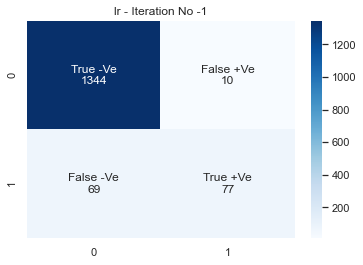

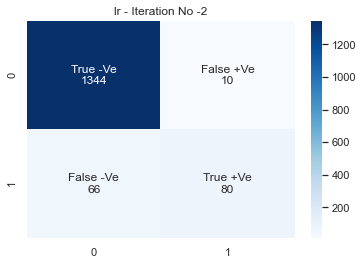

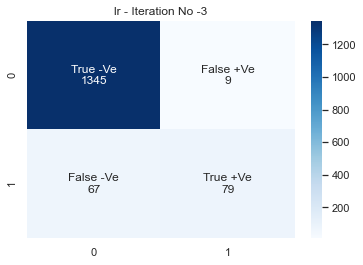

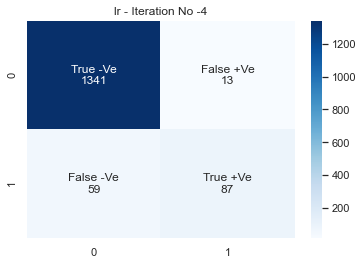

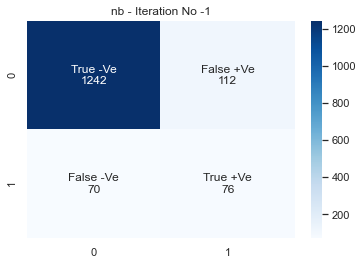

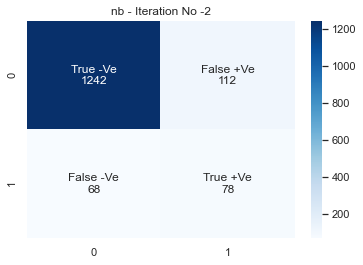

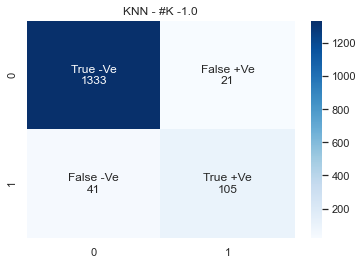

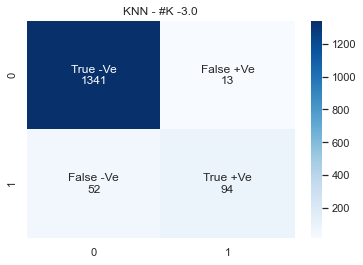

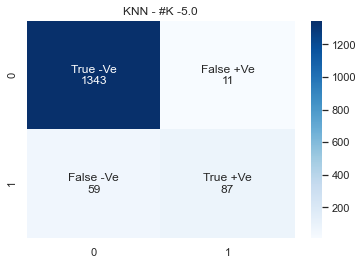

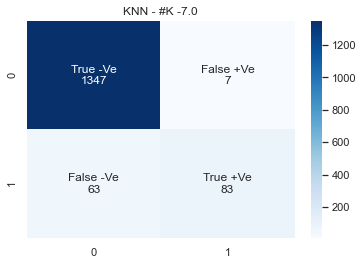

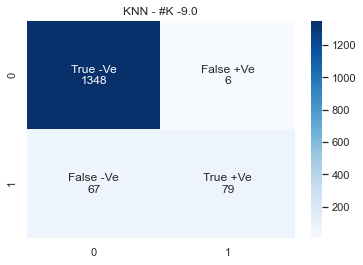

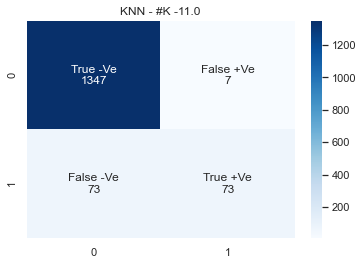

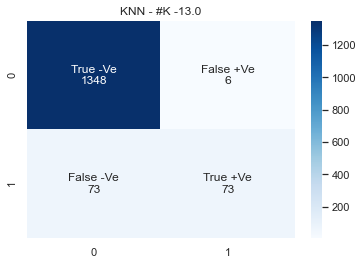

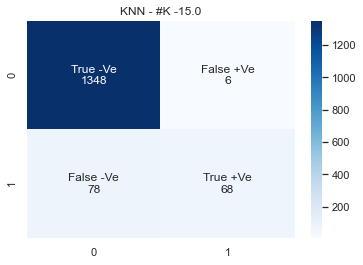

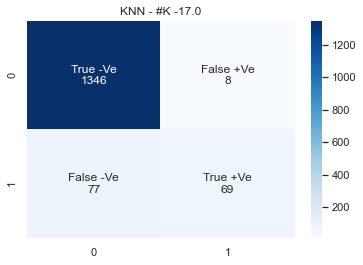

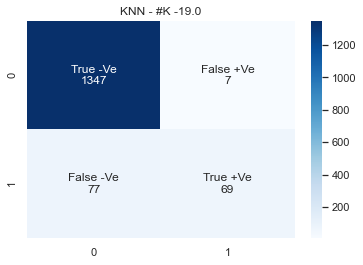

In [42]:
for index in metrics_data_df.index:
    cf_matrix = metrics_data_df["confusion_matrix_obj"][index]
    group_names = ["True -Ve","False +Ve","False -Ve","True +Ve"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)    
    sns.heatmap(cf_matrix, annot=labels,fmt="", cmap='Blues')
    title ="{} - {}".format(metrics_data_df["type"][index],("{}-{}"
                                                            .format("#K ", metrics_data_df["neighbors"][index]) if metrics_data_df["neighbors"][index] > 0 else ("{}-{}".format("Iteration No ", metrics_data_df["iter_no"][index]))))    
    plt.title(title)
    plt.show()

#### **Model comparison**

In [43]:
metrics_data_df

,type,iter_no,neighbors,test_score,train_score,TPR,PPR,f1_score,FPR,roc_auc,confusion_matrix_obj
0,lr,1,NaN,0.95,0.95,0.53,0.89,0.66,0.01,0.76,"[[1344, 10], [69, 77]]"
1,lr,2,NaN,0.95,0.95,0.55,0.89,0.68,0.01,0.77,"[[1344, 10], [66, 80]]"
2,lr,3,NaN,0.95,0.95,0.54,0.90,0.68,0.01,0.77,"[[1345, 9], [67, 79]]"
3,lr,4,NaN,0.95,0.95,0.60,0.87,0.71,0.01,0.79,"[[1341, 13], [59, 87]]"
4,nb,1,NaN,0.88,0.89,0.52,0.40,0.46,0.08,0.72,"[[1242, 112], [70, 76]]"
5,nb,2,NaN,0.88,0.89,0.53,0.41,0.46,0.08,0.73,"[[1242, 112], [68, 78]]"
6,KNN,1,1.0,0.96,1.00,0.72,0.83,0.77,0.02,0.85,"[[1333, 21], [41, 105]]"
7,KNN,2,3.0,0.96,0.98,0.64,0.88,0.74,0.01,0.82,"[[1341, 13], [52, 94]]"
8,KNN,3,5.0,0.95,0.97,0.60,0.89,0.71,0.01,0.79,"[[1343, 11], [59, 87]]"
9,KNN,4,7.0,0.95,0.97,0.57,0.92,0.70,0.01,0.78,"[[1347, 7], [63, 83]]"


Conclusion: ( from above metrics table)
 - KNN ( neighbors = 1 ) ==> model is  overfitting (difference between the Train and test accuracy is high compare to the other models) and so excluded from the analysis.
 
 - **KNN ( neighbors = 3) ==> Best model for the uses case considering the following points**
     - since the bank needs to find the person who will accept the loan  it's important to have high recall 
         - high recall ==> 64 %
         - low False Negative = 52
         - high True Positive = 94
         - high test accuracy = 96 %
         - high F1 score = 74 %
         - High area under the ROC curve - 0.82
     

In [44]:
metrics_data_df.query("type == 'KNN' & neighbors == 3")

,type,iter_no,neighbors,test_score,train_score,TPR,PPR,f1_score,FPR,roc_auc,confusion_matrix_obj
7,KNN,2,3.0,0.96,0.98,0.64,0.88,0.74,0.01,0.82,"[[1341, 13], [52, 94]]"
